# Data Preprocessing

## Load Data and import Packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

# import pymc3 as pm

from matplotlib.patches import Rectangle
plt.rcParams["font.family"] = "serif"

## Initiate Data
- `df_bl`: original baseline data
- `df_sv`: original survey data
- `necessary_sv`: 

['record_id', 'wave', 'wave_name', 'date',  ## Data info

                    
'followingisolation',  ## Compliance index

'soc1', 'soc2', 'soc3', 'soc4', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'phq9', ## depression index

'gad1', 'gad2', 'gad3', 'gad4','gad5', 'gad6','gad7'] ## Anxiety index

- `necessary_bl_reg`:

['country', 'area', 'region', 'living', 'ownership', 

'garden1', 'garden2', 'garden3', 'garden4']

- `necessary_bl_pers`:

['record_id','age', 'age_category', 'gender', 'ethnic', 

'education', 'employment', 'rooms', 'country']


- `df_survey_nec`: `df_sv` with `necessary_sv`
- `df_bl_reg_nec`: `df_bl` with `necessary_bl_reg`
- `df_bl_target` : `df_bl` with `necessary_bl_pers` (Connect the personal_id with the survey entry)


In [5]:
# load the baseline data
df_bl  = pd.read_csv("/Users/nooboo/Desktop/LSE/MY498/data/UKDA-9001-tab/tab/css_baseline_demo.tab", sep="\t")

# load all survey data
df_sv = pd.read_csv("/Users/nooboo/Desktop/LSE/MY498/data/UKDA-9001-tab/tab/css_panel_2020-2022.tab", sep="\t")

# define each columns
necessary_sv = ['record_id', 'wave', 'wave_name', 'date',  ## Data info
                 'followingisolation',  ## Compliance index
                 'soc1', 'soc2', 'soc3', 'soc4', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'phq9', ## depression index
                 'gad1', 'gad2', 'gad3', 'gad4','gad5', 'gad6','gad7'] ## Anxiety index

necessary_bl_reg = ['country', 'area', 'region', 'living', 'ownership', 
                    'garden1', 'garden2', 'garden3', 'garden4']

necessary_bl_pers = ['record_id','age', 'gender', 'ethnic', 
                     'education', 'employment', 'rooms', 'country']

# extract the data for the designated columns
df_survey_nec    = df_sv.loc[:, necessary_sv]
df_bl_region_nec = df_bl.loc[:, necessary_bl_reg]
df_bl_target     = df_bl.loc[:, necessary_bl_pers]

# convert the `date` column into datetime data 
df_survey_nec['date'] = pd.to_datetime(df_survey_nec['date'], format="%m/%d/%Y", errors='coerce')

/Users/nooboo/my498_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (4,69,80,81,83,89,90,91,92,93,94,95,96,97,98,99,100,159,160,161,162,163,164,165,166,167,168) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Get Region Dataframe
- `df_england`: Extract the England country from `df_bl_region_nec`
- `df_leicester`: Extract the Leicster region from `df_bl_region_nec` 
- `england_list`: the list of the index which has the England country
- `leicester_list`: the list of the index which has the Leicster region
- `england_wo_leicester`: the list of the index which belongs to england but not Leicester region

In [6]:
df_england   = df_bl_region_nec.loc[df_bl_region_nec['region'].isin(['1', '2', '3', '4', '5', '6', '7', '8', '9'])]
df_leicester = df_bl_region_nec.loc[df_bl_region_nec['region']=='5']

leicester_list = list(df_leicester.index)
england_list   = list(df_england.index)
england_wo_leicester = [x for x in england_list if x not in leicester_list]

## Merge the data into a master dataframe
### Drop the empty date column
- `df_survey_edit`: Editted version of `df_survey_nec` without empty date column, and the MH indeces

### Make the Target Index (Depression, Anxiety)
- ['depression_index',  'anxiety_index']
- `df_merged`: Merge `df_survey_edit` and `df_bl_target`

### Add Week Number and Days and Leicester or Not
- Add `days_since_min_date` and `week_number` to `df_merged`
- Add `leicester` column to show the entries coming from Leicester

### Categorize the Depression Scale 
- Depression into mild, moderate, moreate severe, severe
- Anxiety into mild, moderate, severe

In [7]:
df_survey_edit = df_survey_nec.copy()

df_survey_edit['date'].loc[df_survey_edit['date']==" "] = np.nan

df_survey_edit = df_survey_edit.dropna(subset=['date'])

phq_cols = [f"phq{i}" for i in range (1, 10)]
gad_cols = [f"gad{i}" for i in range (1, 8)]

convert_cols = phq_cols + gad_cols

for col in convert_cols:
    df_survey_edit[col].loc[df_survey_edit[col]==' '] = np.nan
    df_survey_edit      = df_survey_edit.dropna(subset=[col])
    df_survey_edit[col] = df_survey_edit[col].astype(int)

df_survey_edit['depression_index'] = df_survey_edit.apply(lambda row: row['phq1'] + row['phq2'] + row['phq3'] + row['phq4'] + row['phq5'] + row['phq6'] + row['phq7'] + row['phq8'] + row['phq9'], axis=1)
df_survey_edit['anxiety_index']    = df_survey_edit.apply(lambda row: row['gad1'] + row['gad2'] + row['gad3'] + row['gad4'] + row['gad5'] + row['gad6'] + row['gad7'], axis=1)

df_merged = pd.merge(df_bl_target, df_survey_edit, on='record_id', how='left')

# Step 2: Subtract the min date from each date to get the difference in days
df_merged['days_since_min_date'] = (df_merged['date'] - df_merged['date'].min()).dt.days

df_merged = df_merged.dropna()

# Step 3: Divide the difference by 7 and round down to the nearest integer to get the week number
df_merged['week_number'] = np.floor(df_merged['days_since_min_date'] / 7).astype(int)

df_merged['leicester'] = np.where(df_merged['record_id'].isin(england_wo_leicester), 2, df_merged['record_id'].isin(leicester_list).astype(np.int))

df_merged = df_merged[df_merged['leicester'] != 0]
df_merged['leicester'].loc[df_merged['leicester']==1] = 'Leicester'
df_merged['leicester'].loc[df_merged['leicester']==2] = 'England'

# Categorize the target variable
## depression
df_merged['mild_depression']            = ((df_merged['depression_index']>=5)  & (df_merged['depression_index']<=9)).astype(int)
df_merged['moderate_depression']        = ((df_merged['depression_index']>=10) & (df_merged['depression_index']<=15)).astype(int)
df_merged['moderate_severe_depression'] = ((df_merged['depression_index']>=15) & (df_merged['depression_index']<=19)).astype(int)
df_merged['moderate_and_severe_depression'] = ((df_merged['depression_index']>=10) & (df_merged['depression_index']<=19)).astype(int)
df_merged['severe_depression']          = ((df_merged['depression_index']>=20) & (df_merged['depression_index']<=27)).astype(int)

## anxiety
df_merged['mild_anxiety']     = ((df_merged['anxiety_index']>=5) & (df_merged['depression_index']<=9)).astype(int)
df_merged['moderate_anxiety'] = ((df_merged['anxiety_index']>=10) & (df_merged['depression_index']<=14)).astype(int)
df_merged['moderate_and_severe_anxiety'] = ((df_merged['anxiety_index']>=5) & (df_merged['depression_index']<=14)).astype(int)
df_merged['severe_anxiety']   = (df_merged['anxiety_index']>=15).astype(int)

/Users/nooboo/my498_venv/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/var/folders/xm/__jx4yd975z4mz5rc23cwt_h0000gn/T/ipykernel_90585/812366412.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_merged['leicester'] = np.where(df_merged['record_id'].is

## Define the lockdown period and make a list
- `UK_ld_start_date`: The list of the date of which the lockdown starts
- `UK_ld_end_date`: The list of the date of which the lockdown ends
- `UK_ld_start_weeks`: The list of the week of which the lockdown starts
- `UK_ld_end_weeks`: The list of the week of which the lockdown ends

In [8]:
UK_ld_start = pd.to_datetime(["2020-03-23", "2020-07-04", "2020-11-05", "2021-01-06"])
UK_ld_end   = pd.to_datetime(["2020-06-23", "2020-09-15", "2020-12-02", "2021-03-15"])

LS_ld_late  = pd.to_datetime(["2020-07-18", "2020-07-24", "2020-08-01", "2020-08-19", "2020-09-08", "2020-09-15"]) 

# Get the minimum date from your original 'date' column
min_date = pd.to_datetime(df_merged['date']).min()


# Subtract min_date from each lockdown date and convert to weeks
UK_ld_start_weeks = list(((UK_ld_start - min_date).days / 7).astype(int))
UK_ld_end_weeks   = list(((UK_ld_end   - min_date).days / 7).astype(int))
LS_ld_late_weeks  = list(((LS_ld_late  - min_date).days / 7).astype(int))

UK_ld_start_date = list(((UK_ld_start - min_date).days).astype(int))
UK_ld_end_date   = list(((UK_ld_end   - min_date).days).astype(int))
LS_ld_late_date  = list(((LS_ld_late  - min_date).days).astype(int))

# Plotting

In [9]:
# We only use data until 2021-5-1
df_plot = df_merged.loc[df_merged['date'] <= '2021-05-01']

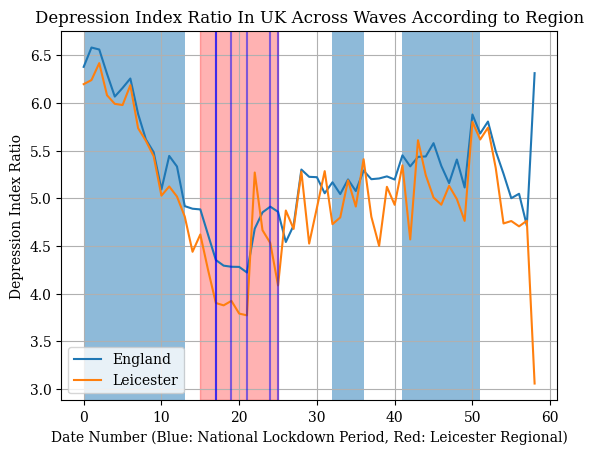

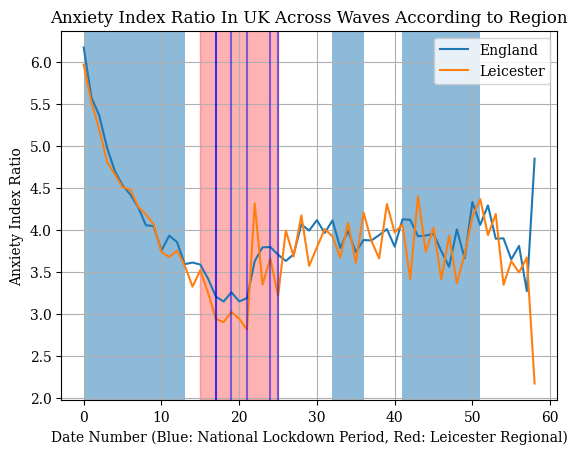

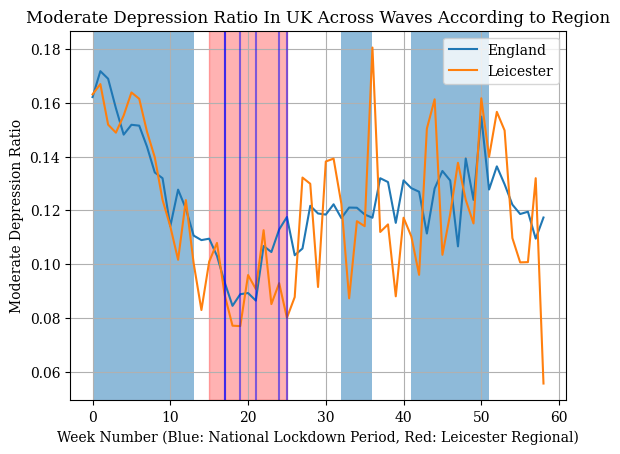

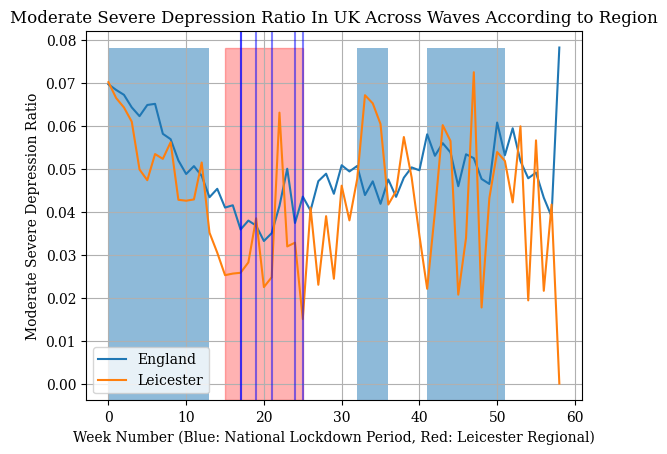

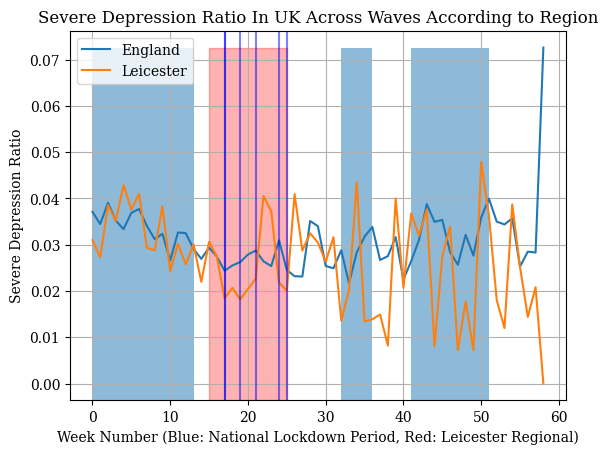

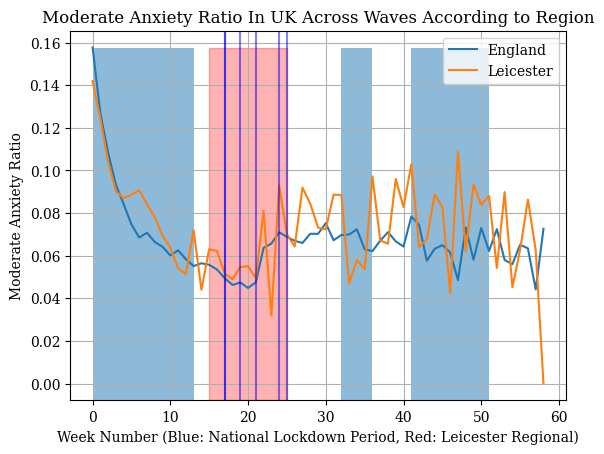

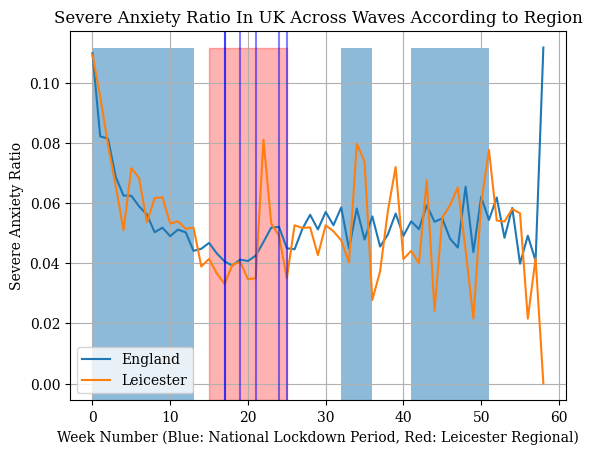

In [10]:
def weekly_leicester_ts_plot(col, name, xlabel="Week Number"):
    df = df_plot.groupby(['week_number', 'leicester'])[col].agg(['sum', 'count']).reset_index()
    df[f'{col}_ratio'] = df['sum'] / df['count']
    # age_categories = df['leicster'].unique()
    age_categories = df[df['leicester'].isin(['Leicester', 'England'])]['leicester'].unique() 

    for category in age_categories:
        df_subset = df[df['leicester'] == category]
        plt.plot(df_subset['week_number'], df_subset[f'{col}_ratio'], label=category)
        # plt.plot(df_subset['week_number'], df_subset['sum'], label=category)

    # Add a rectangle for a total of 4 lockdowns
    for i in range(4):
        if i==1:
            ld = Rectangle((UK_ld_start_weeks[i], plt.ylim()[0]), 
                            UK_ld_end_weeks[i] - UK_ld_start_weeks[i], plt.ylim()[1], 
                            alpha=0.3,
                            color='red')
        else:
            ## i-th Lockdown
            ld = Rectangle((UK_ld_start_weeks[i], plt.ylim()[0]), 
                            UK_ld_end_weeks[i] - UK_ld_start_weeks[i], plt.ylim()[1], 
                            alpha=0.5)

    # Add the rectangle to the plot
        plt.gca().add_patch(ld)

    for j in range(len(LS_ld_late_weeks)):
        plt.axvline(x = LS_ld_late_weeks[j], color = 'b', alpha=0.5)

    plt.title(f'{name} Ratio In UK Across Waves According to Region')
    plt.xlabel(xlabel)
    plt.ylabel(f'{name} Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

weekly_leicester_ts_plot(col='depression_index',        
                        name='Depression Index',
                        xlabel='Date Number (Blue: National Lockdown Period, Red: Leicester Regional)')

weekly_leicester_ts_plot(col='anxiety_index',        
                        name='Anxiety Index',
                        xlabel='Date Number (Blue: National Lockdown Period, Red: Leicester Regional)')


# weekly_leicester_ts_plot(col='mild_depression',
#                          name='Mild Depression',
#                          xlabel='Week Number (Blue: National Lockdown Period, Red: Leicester Regional)')
weekly_leicester_ts_plot(col='moderate_depression',        
                         name='Moderate Depression',
                         xlabel='Week Number (Blue: National Lockdown Period, Red: Leicester Regional)')
weekly_leicester_ts_plot(col='moderate_severe_depression', 
                         name='Moderate Severe Depression',
                         xlabel='Week Number (Blue: National Lockdown Period, Red: Leicester Regional)')
weekly_leicester_ts_plot(col='severe_depression',          
                         name='Severe Depression', 
                         xlabel='Week Number (Blue: National Lockdown Period, Red: Leicester Regional)')

# weekly_leicester_ts_plot(col='mild_anxiety',
#                          name='Mild Anxiety',
#                          xlabel='Week Number (Blue: National Lockdown Period, Red: Leicester Regional)')
weekly_leicester_ts_plot(col='moderate_anxiety',        
                         name='Moderate Anxiety',
                         xlabel='Week Number (Blue: National Lockdown Period, Red: Leicester Regional)')
weekly_leicester_ts_plot(col='severe_anxiety',          
                         name='Severe Anxiety', 
                         xlabel='Week Number (Blue: National Lockdown Period, Red: Leicester Regional)')


## Smooth each of the plot using moving average

In [11]:
# Function of the moving average
def MovingAverage(df, col, num_days=7):
  
  # modify into a pd.timedata to make modification
  init_date, max_date = min(df['days_since_min_date']), max(df['days_since_min_date'])
  # initialize current date
  current_date = init_date
  nan_region   = num_days-1
  # we put na values for the first `num_days - 1` days
  while current_date <= max_date:
    current_idx = current_date
    if current_date <= nan_region:
      df.loc[current_idx, col+f'_MA_{num_days}days'] = np.nan 

    else:
      # get the data of the `num_days` days behind from the data
      date_range  = list(i for i in range(int(current_date) - num_days, int(current_date)))
      rolling_sum, rolling_count = df.loc[date_range]['sum'].mean(), df.loc[date_range]['count'].mean()
      rolling_avg = rolling_sum / rolling_count
      df.loc[current_idx, col+f'_MA_{num_days}days'] = rolling_avg

    current_date += 1

  return df

def daily_MA_leicester_ts_plot(col, name, xlabel="Date Number", num_days=15):
    df = df_plot.groupby(['days_since_min_date', 'leicester'])[col].agg(['sum', 'count']).reset_index()
    df[f'{col}_ratio'] = df['sum'] / df['count']
    # age_categories = df['leicster'].unique()
    age_categories = df[df['leicester'].isin(['Leicester', 'England'])]['leicester'].unique() 

    for category in age_categories:
        df_subset = df[df['leicester'] == category].reset_index()
        df_plot_MA = MovingAverage(df_subset, col, num_days=num_days)
        plt.plot(df_plot_MA['days_since_min_date'], df_plot_MA[f'{col}_MA_{num_days}days'], label=category)

    # Add a rectangle for a total of 4 lockdowns
    for i in range(4):
        if i==1:
            ld = Rectangle((UK_ld_start_date[i], plt.ylim()[0]), 
                            UK_ld_end_date[i] - UK_ld_start_date[i], plt.ylim()[1], 
                            alpha=0.3,
                            color='red')
        else:
            ## i-th Lockdown
            ld = Rectangle((UK_ld_start_date[i], plt.ylim()[0]), 
                            UK_ld_end_date[i] - UK_ld_start_date[i], plt.ylim()[1], 
                            alpha=0.5)

    # Add the rectangle to the plot
        plt.gca().add_patch(ld)
    
    for j in range(len(LS_ld_late_date)):
        plt.axvline(x = LS_ld_late_date[j], color = 'b', alpha=0.5)


    plt.title(f'{name} Ratio In UK Across Waves According to Region')
    plt.xlabel(xlabel)
    plt.ylabel(f'{name} Ratio MA ({num_days} days)')
    plt.legend()
    plt.grid(True)
    plt.show()

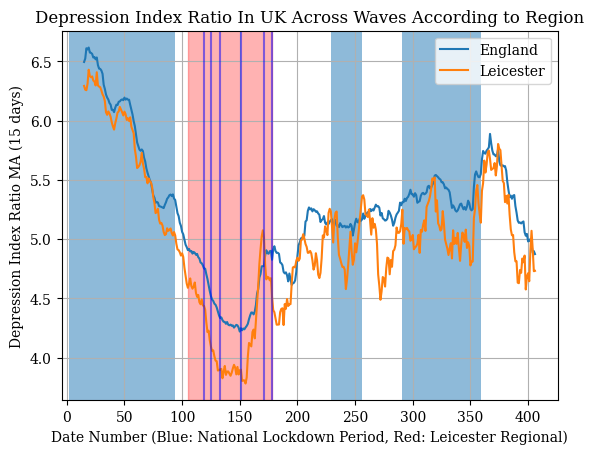

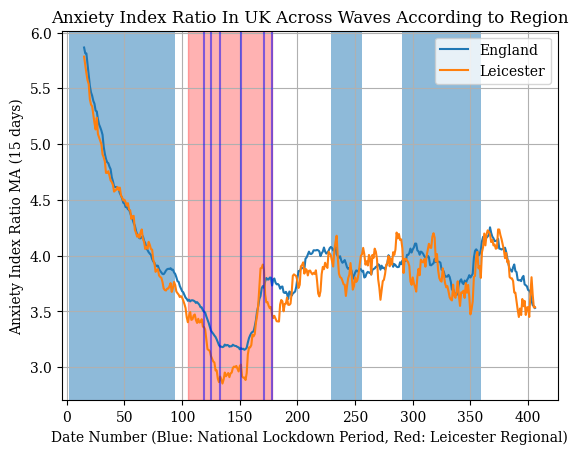

In [12]:
daily_MA_leicester_ts_plot(col='depression_index',        
                        name='Depression Index',
                        xlabel='Date Number (Blue: National Lockdown Period, Red: Leicester Regional)')

daily_MA_leicester_ts_plot(col='anxiety_index',        
                        name='Anxiety Index',
                        xlabel='Date Number (Blue: National Lockdown Period, Red: Leicester Regional)')

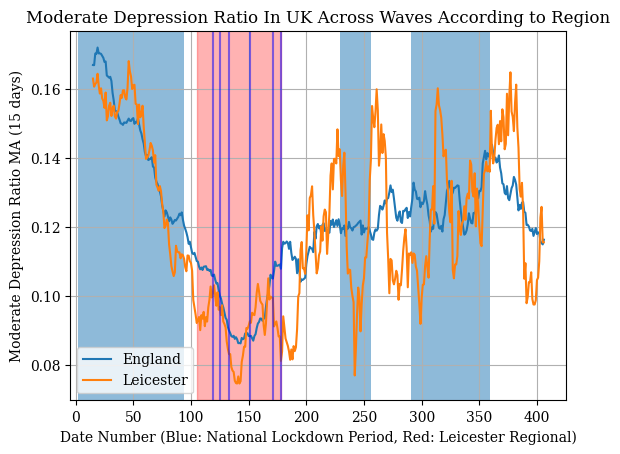

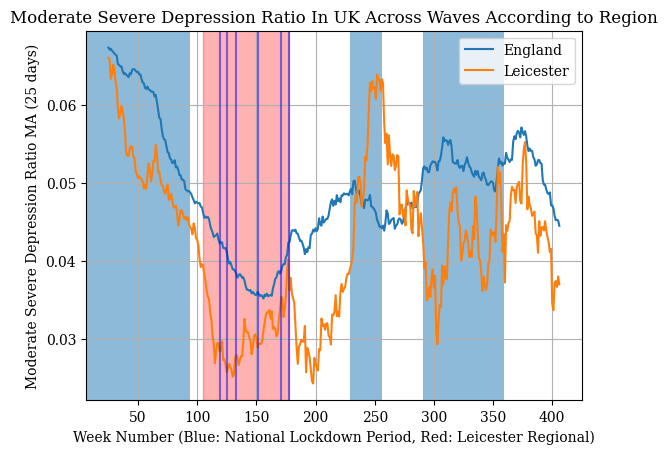

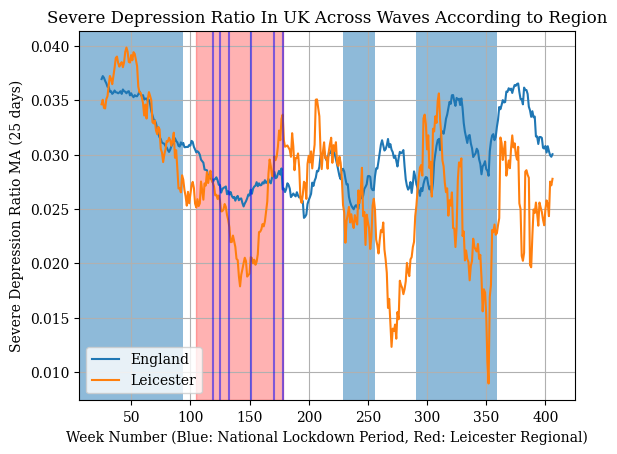

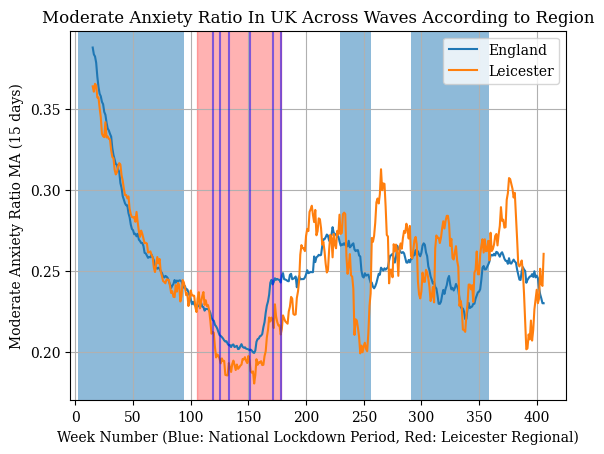

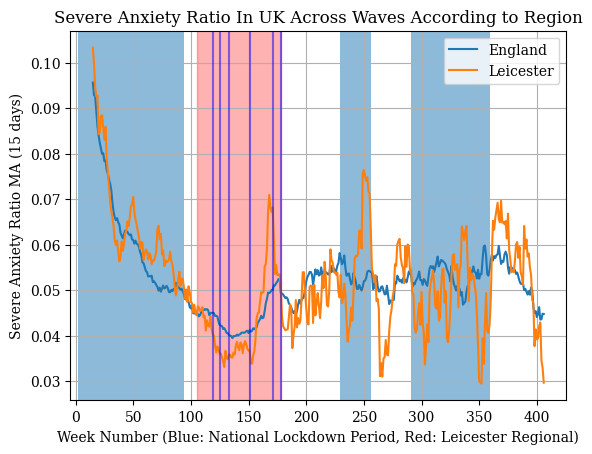

In [13]:
daily_MA_leicester_ts_plot(col='moderate_depression',        
                        name='Moderate Depression',
                        xlabel='Date Number (Blue: National Lockdown Period, Red: Leicester Regional)')

daily_MA_leicester_ts_plot(col='moderate_severe_depression', 
                         name='Moderate Severe Depression',
                         xlabel='Week Number (Blue: National Lockdown Period, Red: Leicester Regional)',
                         num_days=25)

daily_MA_leicester_ts_plot(col='severe_depression',          
                         name='Severe Depression', 
                         xlabel='Week Number (Blue: National Lockdown Period, Red: Leicester Regional)',
                         num_days=25)

daily_MA_leicester_ts_plot(col='moderate_and_severe_anxiety',        
                         name='Moderate Anxiety',
                         xlabel='Week Number (Blue: National Lockdown Period, Red: Leicester Regional)')

daily_MA_leicester_ts_plot(col='severe_anxiety',          
                         name='Severe Anxiety', 
                         xlabel='Week Number (Blue: National Lockdown Period, Red: Leicester Regional)')

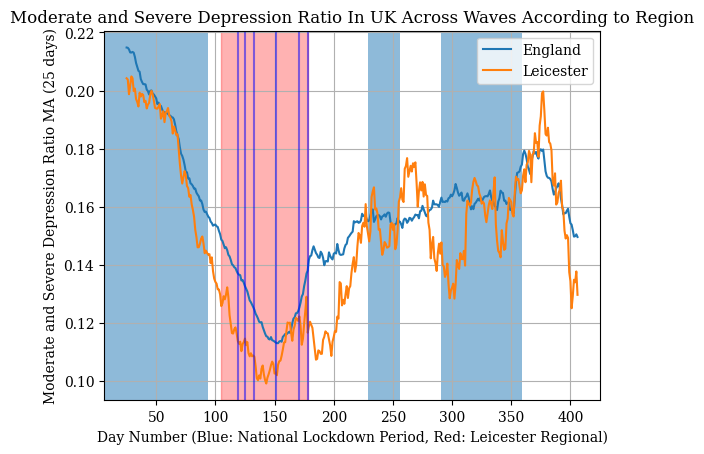

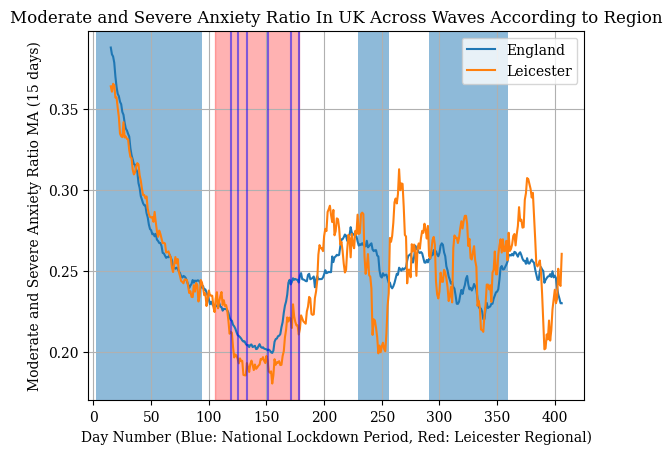

In [14]:
daily_MA_leicester_ts_plot(col='moderate_and_severe_depression',          
                         name='Moderate and Severe Depression', 
                         xlabel='Day Number (Blue: National Lockdown Period, Red: Leicester Regional)',
                         num_days=25)

daily_MA_leicester_ts_plot(col='moderate_and_severe_anxiety',        
                         name='Moderate and Severe Anxiety',
                         xlabel='Day Number (Blue: National Lockdown Period, Red: Leicester Regional)')

In [22]:
## We would get the data until the 25th of July (where Leicester is the only region that is implementing LD)
df_did = df_merged.loc[df_merged['date'] <= '2020-07-24'].reset_index(drop=True)
display(df_did)

,record_id,age,gender,ethnic,education,employment,rooms,country,wave,wave_name,...,leicester,mild_depression,moderate_depression,moderate_severe_depression,moderate_and_severe_depression,severe_depression,mild_anxiety,moderate_anxiety,moderate_and_severe_anxiety,severe_anxiety
0,4,40,1,2,4,5,5,2,1.0,week_1,...,England,0,0,0,0,0,0,0,0,0
1,4,40,1,2,4,5,5,2,2.0,week_2,...,England,0,0,0,0,0,0,0,0,0
2,4,40,1,2,4,5,5,2,3.0,week_3,...,England,0,0,0,0,0,0,0,0,0
3,4,40,1,2,4,5,5,2,4.0,week_4,...,England,0,0,0,0,0,0,0,0,0
4,4,40,1,2,4,5,5,2,5.0,week_5,...,England,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177018,73208,66,2,1,6,9,9,1,7.0,week_7,...,England,1,0,0,0,0,1,1,1,1
177019,73208,66,2,1,6,9,9,1,8.0,week_8,...,England,0,1,0,1,0,0,1,1,1
177020,73208,66,2,1,6,9,9,1,9.0,week_9,...,England,0,1,0,1,0,0,1,1,1
177021,73209,54,2,1,2,5,5,1,1.0,week_1,...,England,1,0,0,0,0,0,0,0,0


In [42]:
# df_did['D'] = np.where((df_did['date'] > '2020-07-04') & (df_did['leicester'] == 'Leicester'), 1, 0)
df_did['G'] = np.where((df_did['leicester'] == 'Leicester'), 105, 0)
df_did['D'] = np.where((df_did['date'] > '2020-07-04') & (df_did['leicester'] == 'Leicester'), 1, 0)

In [41]:
min(df_did['days_since_min_date'][df_did['date'] > '2020-07-04'])

106.0

In [43]:
df_did.to_csv("/Users/nooboo/Desktop/LSE/MY498/data/df_DiD.csv")

## Balance Test
- Checking Each Covariates if there are any balance

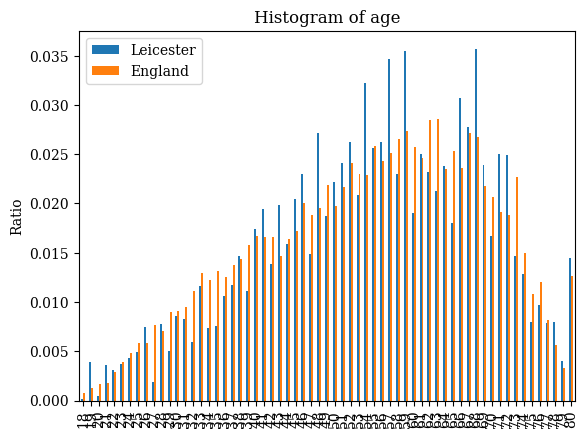

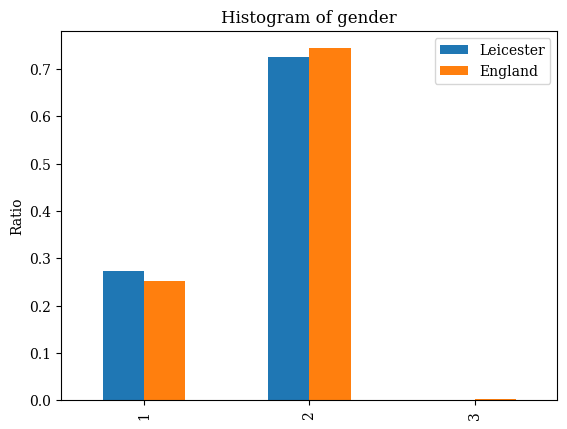

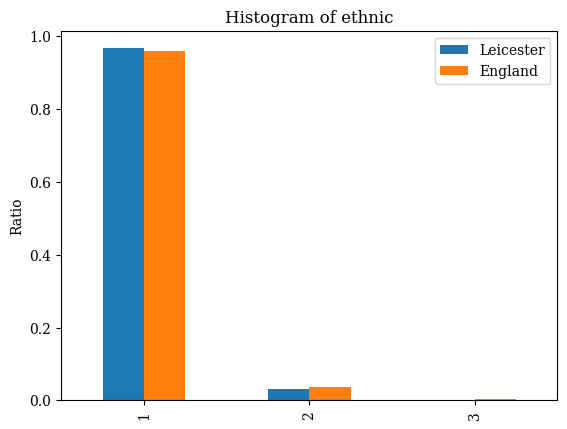

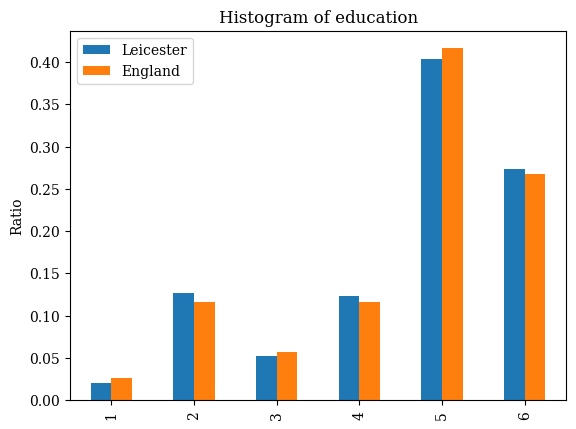

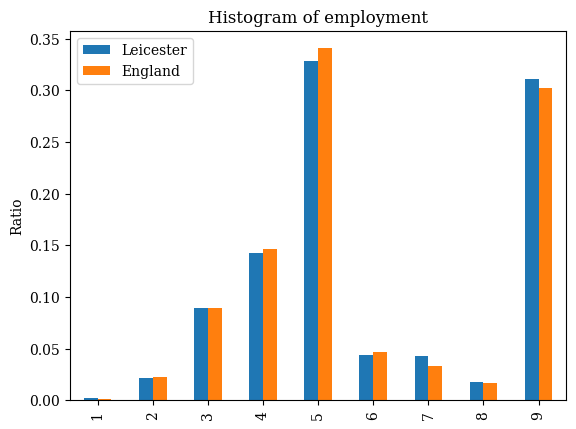

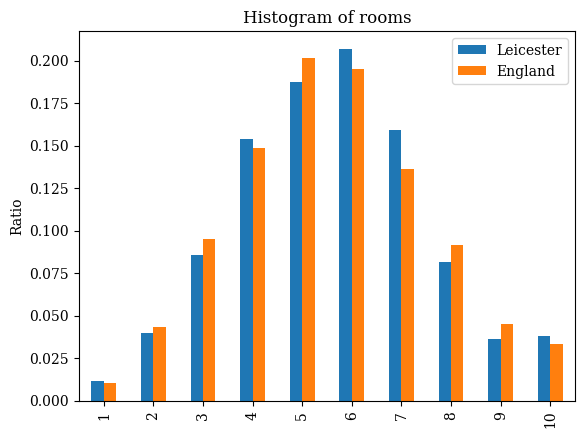

In [151]:
covariate_list = ['age', 'gender', 'ethnic', 'education', 'employment', 'rooms']

def bt_covariate(df, col):
    # Divide the dataframe into two based on 'leicester' column values
    leicester = df[df['leicester'] == 'Leicester']
    england   = df[df['leicester'] == 'England']

    # Calculate ratio for each category
    leicester_values = leicester[col].value_counts(normalize=True)
    england_values   = england[col].value_counts(normalize=True)

    # Concatenate the two series into a dataframe for easy plotting
    df_combined = pd.concat([leicester_values, england_values], axis=1)
    df_combined.columns = ['Leicester', 'England']

    # Fill NaN values with 0
    df_combined.fillna(0, inplace=True)

    # Plotting
    df_combined.sort_index().plot(kind='bar', stacked=False)
    plt.title('Histogram of ' + col)
    plt.ylabel('Ratio')
    plt.show()


for cov in covariate_list:
    bt_covariate(df_merged, cov)

/var/folders/xm/__jx4yd975z4mz5rc23cwt_h0000gn/T/ipykernel_3616/1959485695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['gender'] = df_temp['gender'].astype(str)


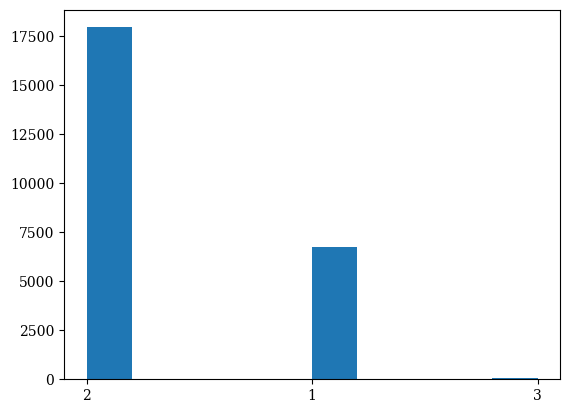

In [137]:
category = 'Leicester'
df_temp = df_merged[df_merged['leicester'] == category]
df_temp['gender'] = df_temp['gender'].astype(str)


plt.hist(df_temp['gender'])
plt.show() 

## Difference in Difference
- Fit the regression and assess the difference
- 

In [73]:
df_did['depression_index']

,record_id,age,gender,ethnic,education,employment,rooms,country,wave,wave_name,...,week_number,leicester,mild_depression,moderate_depression,moderate_severe_depression,severe_depression,mild_anxiety,moderate_anxiety,severe_anxiety,D
0,4,40,1,2,4,5,5,2,1.0,week_1,...,2,England,0,0,0,0,0,0,0,0
1,4,40,1,2,4,5,5,2,2.0,week_2,...,4,England,0,0,0,0,0,0,0,0
2,4,40,1,2,4,5,5,2,3.0,week_3,...,5,England,0,0,0,0,0,0,0,0
3,4,40,1,2,4,5,5,2,4.0,week_4,...,6,England,0,0,0,0,0,0,0,0
4,4,40,1,2,4,5,5,2,5.0,week_5,...,7,England,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177018,73208,66,2,1,6,9,9,1,7.0,week_7,...,14,England,1,0,0,0,1,1,1,0
177019,73208,66,2,1,6,9,9,1,8.0,week_8,...,16,England,0,1,0,0,0,1,1,0
177020,73208,66,2,1,6,9,9,1,9.0,week_9,...,17,England,0,1,0,0,0,1,1,0
177021,73209,54,2,1,2,5,5,1,1.0,week_1,...,6,England,1,0,0,0,0,0,0,0


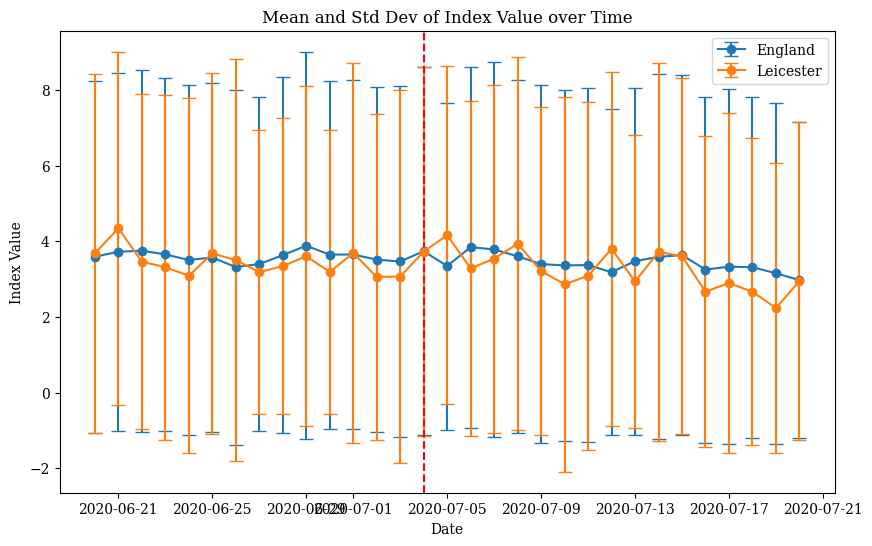

In [83]:
# Lead-Lag plot
import matplotlib.pyplot as plt
import pandas as pd

# Convert the 'date' column to datetime
df_did['date'] = pd.to_datetime(df_did['date'])

# Select data until '2020-07-25'
df_did = df_did[(df_did['date'] >= '2020-06-20') & (df_did['date'] <= '2020-07-20')]

# Split the dataframe into two based on 'leicester' column
df_england   = df_did[df_did['leicester'] == 'England']
df_leicester = df_did[df_did['leicester'] == 'Leicester']

# Calculate mean and standard deviation for each date for both England and Leicester
df_grouped_england   = df_england.groupby('date')['anxiety_index'].agg(['mean', 'std']).reset_index()
df_grouped_leicester = df_leicester.groupby('date')['anxiety_index'].agg(['mean', 'std']).reset_index()

# Create plot
plt.figure(figsize=(10, 6))

# Plot for England
plt.errorbar(df_grouped_england['date'], df_grouped_england['mean'], yerr=df_grouped_england['std'], 
             fmt='-o', capsize=5, label='England')

# Plot for Leicester
plt.errorbar(df_grouped_leicester['date'], df_grouped_leicester['mean'], yerr=df_grouped_leicester['std'], 
             fmt='-o', capsize=5, label='Leicester')

# Add a vertical line
plt.axvline(pd.to_datetime('2020-07-04'), color='r', linestyle='--')

# Set x-axis label
plt.xlabel('Date')

# Set y-axis label
plt.ylabel('Index Value')

# Set plot title
plt.title('Mean and Std Dev of Index Value over Time')

# Add legend
plt.legend()

# Show the plot
plt.show()


## Bayesian DiD

## OxCGRT Plot

In [24]:
df_oxcgrt = pd.read_csv("/Users/nooboo/Desktop/MY498_data/oxcgr/UK_oxcgrt.csv")
df_oxcgrt.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1E_School closing', 'C1E_Flag',
       'C1NV_School closing', 'C1NV_Flag',
       ...
       'StringencyIndex_WeightedAverage',
       'GovernmentResponseIndex_NonVaccinated',
       'GovernmentResponseIndex_Vaccinated',
       'GovernmentResponseIndex_SimpleAverage',
       'GovernmentResponseIndex_WeightedAverage',
       'ContainmentHealthIndex_NonVaccinated',
       'ContainmentHealthIndex_Vaccinated',
       'ContainmentHealthIndex_SimpleAverage',
       'ContainmentHealthIndex_WeightedAverage', 'EconomicSupportIndex\'],
      dtype='object', length=147)